# Machine Learning

## Set up

In [156]:
# Set up folders
from EDA_functions import folders_set_up
import os

# Work with datarames
import pandas as pd
import numpy as np

# Charts
import seaborn as sns
from matplotlib import pyplot as plt

# X, Y preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# SVR
from sklearn.svm import SVR

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout
from keras.optimizers import Adam, SGD

# Pipeline
from sklearn.pipeline import Pipeline

# Evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#from scipy.sparse import spmatrixc

In [157]:
# Light GBM
# import lightgbm as lgb

### Folders
Run the code below if you have the following structure:
- Group-project: GitHub folder
- 01 Input
- 02 Output

In [158]:
analysis_folder, input_folder, output_folder = folders_set_up.generate_folders()

## Import and merge data

### Datasets

In [159]:
#Title-level dataset with embeddings
title_embeddings_df = pd.read_pickle(
    os.path.join(output_folder, 'English_fiction_pre_PCA_3_with_av_pool_embeddings')
)

title_embeddings_df.columns

Index(['index', 'Title', 'description', 'authors', 'image', 'previewLink',
       'publisher', 'infoLink', 'categories', 'reviews number',
       'average rating', 'median rating', 'min review date', 'max review date',
       'weighted rating', 'date', 'year', 'description_language', 'Embedding'],
      dtype='object')

### Format data

In [160]:
title_embeddings_df.dtypes

index                     int64
Title                    object
description              object
authors                  object
image                    object
previewLink              object
publisher                object
infoLink                 object
categories               object
reviews number            int64
average rating          float64
median rating           float64
min review date          object
max review date          object
weighted rating         float64
date                     object
year                    float64
description_language     object
Embedding                object
dtype: object

#### Date

In [161]:
dates_columns = ['min review date', 'max review date', 'date']

for date in dates_columns:
    # get date from strings with time
    title_embeddings_df[date] = title_embeddings_df[date].str.split().str[0]
    # convert in datetime
    title_embeddings_df[date] = pd.to_datetime(title_embeddings_df[date])

In [162]:
title_embeddings_df[dates_columns].isna().sum()

min review date    0
max review date    0
date               0
dtype: int64

In [163]:
# NOTE: we work on a subset of data for now to make the ML run faster
#title_embeddings_df = title_embeddings_df.sample(n=1000, random_state=42)

#### Image embeddings
These need may need to be transformed in from arrays to columns if the model we use is not NN

### Clean data
Most of the cleaning is done in '02 Consolidate books dataset':
- English description
- category containing the word 'fiction'
- non-missing date
- non-missing author
- non-missing publisher
- non-missing cover image

## X and y set up

### Train test split

In [164]:
title_embeddings_df.columns

Index(['index', 'Title', 'description', 'authors', 'image', 'previewLink',
       'publisher', 'infoLink', 'categories', 'reviews number',
       'average rating', 'median rating', 'min review date', 'max review date',
       'weighted rating', 'date', 'year', 'description_language', 'Embedding'],
      dtype='object')

In [165]:
# Create X and y including all X features and all all teh possible target variables
# NOTE: we will have to add the description PCA in X_features
X_columns = ['year', 'Embedding', 'index', 'Title']

X = title_embeddings_df[X_columns]
y = title_embeddings_df[['average rating', 'weighted rating']]

In [166]:
X.columns

Index(['year', 'Embedding', 'index', 'Title'], dtype='object')

In [167]:
y.columns

Index(['average rating', 'weighted rating'], dtype='object')

In [168]:
# Create train test split

# Need to create train test split for different combinations of data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size= 0.2, 
    random_state= 42,
)

In [169]:
# store indices of train test split for the NLP of description
train_indices = X_train[['Title', 'index']]
test_indices = X_test[['Title', 'index']]

train_indices.to_csv(
    os.path.join(output_folder, 'train_indices.csv')
)


test_indices.to_csv(
    os.path.join(output_folder, 'test_indices.csv')
)

### Add NLP output

#### Import data

In [170]:
# Description NLP test
NLP_df_test = pd.read_csv(
    os.path.join(output_folder, 'X_test_tSVD_3000.csv')
)

NLP_df_test.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'index', 'reviews number',
       ...
       'tSVD2991', 'tSVD2992', 'tSVD2993', 'tSVD2994', 'tSVD2995', 'tSVD2996',
       'tSVD2997', 'tSVD2998', 'tSVD2999', 'tSVD3000'],
      dtype='object', length=3019)

In [171]:
# Description NLP train
NLP_df_train = pd.read_csv(
    os.path.join(output_folder, 'X_train_tSVD_3000.csv')
)
NLP_df_train.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'index', 'reviews number',
       ...
       'tSVD2991', 'tSVD2992', 'tSVD2993', 'tSVD2994', 'tSVD2995', 'tSVD2996',
       'tSVD2997', 'tSVD2998', 'tSVD2999', 'tSVD3000'],
      dtype='object', length=3019)

#### Keep relevant variables

In [172]:
columns_to_keep = ['index'] + [col for col in NLP_df_test.columns if col.startswith('tSVD')]

NLP_df_train = NLP_df_train[columns_to_keep]
NLP_df_test = NLP_df_test[columns_to_keep]

#### Create train test datasets including description and embeddings

In [173]:
# Merge X train with NLP train split
X_train_full = pd.merge(
    X_train,
    NLP_df_train,
    on = 'index',
    how = 'inner'
)

X_train_full.columns

Index(['year', 'Embedding', 'index', 'Title', 'tSVD1', 'tSVD2', 'tSVD3',
       'tSVD4', 'tSVD5', 'tSVD6',
       ...
       'tSVD2991', 'tSVD2992', 'tSVD2993', 'tSVD2994', 'tSVD2995', 'tSVD2996',
       'tSVD2997', 'tSVD2998', 'tSVD2999', 'tSVD3000'],
      dtype='object', length=3004)

In [174]:
# Merge X train with NLP test split
X_test_full = pd.merge(
    X_test,
    NLP_df_test,
    on = 'index',
    how = 'inner'
)

X_test_full.columns

Index(['year', 'Embedding', 'index', 'Title', 'tSVD1', 'tSVD2', 'tSVD3',
       'tSVD4', 'tSVD5', 'tSVD6',
       ...
       'tSVD2991', 'tSVD2992', 'tSVD2993', 'tSVD2994', 'tSVD2995', 'tSVD2996',
       'tSVD2997', 'tSVD2998', 'tSVD2999', 'tSVD3000'],
      dtype='object', length=3004)

In [175]:
# Remove Title and idex
X_train_full = X_train_full.drop(['Title', 'index'], axis = 1)
X_test_full = X_test_full.drop(['Title', 'index'], axis = 1)

### Create X and y cuts
We are going to run two models for two target variables
- Target variable: Average rating
  - baseline (i.e. excluding image embeddings)
  - including image embeddings
- Target variable: weighted rating
  - baseline (i.e. excluding image embeddings)
  - including image embeddings

We therefore need to create the following datsets
- X train and X test with embeddings
- X train and X text without embeddings
- y train and y test using average rating
- y train and y test using weighted rating

#### Baseline X and y

In [176]:
# Baseline model data
X_baseline_train = X_train_full.drop('Embedding', axis = 1)
X_baseline_test = X_test_full.drop('Embedding', axis = 1)

# Y train with average rating
y_avg_r_train = y_train['average rating']
y_avg_r_test = y_test['average rating']

# Y train with weighted rating
y_wr_train = y_train['weighted rating']
y_wr_test = y_test['weighted rating']

In [177]:
print(X_baseline_train.shape)
print(X_baseline_test.shape)

(21419, 3001)
(5355, 3001)


#### Embeddings X

In [178]:
X_images_train = X_train['Embedding'].apply(pd.Series)
X_images_test = X_test['Embedding'].apply(pd.Series)

In [179]:
X_images_test

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
18094,1.836475,-0.497749,-0.934198,-0.700033,-0.183123,-0.457912,-0.280106,-0.600373,1.840422,0.901016,...,2.104014,1.616048,-2.514497,-4.208746,-0.098694,1.582575,0.489796,1.575465,1.193311,-2.050111
9755,0.205656,0.791968,0.405043,-1.060780,0.118351,-1.244569,-1.545293,-0.671695,-0.686115,1.250351,...,0.078643,-2.672630,-3.056665,-1.075442,0.566942,1.214506,-0.765949,-0.835964,1.480691,-1.776814
21240,0.930151,0.571199,-2.055533,-1.008831,1.015776,0.384367,0.314018,0.082096,0.733199,0.296620,...,0.742268,-1.222809,-2.141979,-0.946069,-0.660697,-0.262918,-0.767982,1.251583,0.774267,-1.925034
6725,1.278287,1.026899,-1.305843,-0.473169,-0.343535,-0.259604,-0.285320,0.125091,0.764422,-1.185505,...,2.278345,-0.392527,-0.233589,-1.632104,1.350724,-0.440483,0.112697,1.445008,1.684287,-2.700428
8882,2.203120,1.502297,-1.191875,-0.953792,-0.141903,0.928510,-0.490275,-0.237004,2.103021,-0.426597,...,0.912975,-0.281342,-2.052552,-1.181523,-0.322459,-1.299769,-1.665321,0.238138,1.767898,-1.486802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096,1.050755,-1.591885,-2.350058,-0.953110,0.647061,-0.311001,-0.748348,0.373362,-0.387882,1.047025,...,-0.200192,0.252263,-1.823197,-2.419869,-0.559653,1.133909,-0.333365,0.801189,-0.999478,-3.890836
14807,1.474814,-0.414877,-1.244418,0.905722,0.142872,-0.770006,-0.378338,1.122426,0.560395,-0.992234,...,1.176295,1.091057,-1.040878,1.289441,-0.142611,-0.594793,-0.160397,-0.775595,2.140052,-1.167046
7376,0.104982,-1.683177,-2.318883,0.529517,-0.592815,0.895470,-2.075084,-0.088912,1.376224,-0.365895,...,1.459096,-0.379034,0.950986,-1.437364,-0.515036,-0.798989,0.203845,2.042672,2.153734,-0.287360
21911,1.764822,0.718472,-0.340942,-0.222711,-1.331447,-0.147405,-2.655680,-0.189822,0.872460,-1.348953,...,-0.761795,-1.367549,-1.470985,-1.775654,0.239348,-0.552941,-1.093193,-0.551422,0.974623,-1.854537


### Description dimension reduction NN

-> Questions/notes:
Inputs to choose:
- number of layers:
    - Description NN
        - input
        - noise
        - hidden layer
        - noise
        - hidden layer
        - final layer
    - Description and image embeddings NN
        - input
        - noise
        - hidden layer
        - noise
        - final layer
    Too many?   
- add dense layers to avoid overfitting?
- activation functions
    - ReLu (Rectified linear activation function): piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. Simple but effective.
- Use linear in the last layer to obtain a continuous variable
- optimizer: 
    - Adam; works with momentums of first and second order. 
    - sdg: variant of Gradient Descent (Gradient Descent is the most basic but most used optimization algorithm. It’s used heavily in linear regression and classification algorithms. It's easy and works well but there is the risk that the model gets stuck in local minima)
- loss function
    - MSE?
- number of epochs
- which metric to use to evaluate the model?
    - MSE
    - MAE

- Use gridsearch to optimise hyperparameters?

In [180]:
X_baseline_train.shape

(21419, 3001)

#### Set up

In [181]:
X_baseline_train.shape[1]

3001

In [182]:
# get number of inputs - second element of shape (i.e. number of columns in X)
input_shape = X_baseline_train.shape[1]

# neurons number
n_neurons = 512

# define a model
baseline_model = keras.Sequential()

# Add input layer
baseline_model.add(layers.Dense(
            n_neurons, # number of neurons
            input_dim = input_shape, # number of inputs 
            activation = 'relu' # activation faunction
            ))

# Hidden - Layers
baseline_model.add(layers.Dense(
                    256, 
                    activation = "linear"))

baseline_model.summary()

/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │     1,537,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,668,352 (6.36 MB)

 Trainable params: 1,668,352 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile

In [183]:
# Compile model

baseline_model.compile(
    optimizer='adam',
    loss=['mean_squared_error'], 
    metrics = ['mae', 'mean_squared_error']
    )

#### Train

In [184]:
# Train model
epochs_hist = baseline_model.fit(
    X_baseline_train, # input
    y_wr_train, # output
    epochs=100, # number of iterations
    batch_size=50, # number of observations taken to train the data
    verbose=1,
    validation_data = (X_baseline_test, y_wr_test),
    shuffle = True
    #validation_split=0.2,    
)

Epoch 1/100
  9/429 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 743.7336 - mae: 18.9162 - mean_squared_error: 743.7335      

429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 54.7727 - mae: 2.4568 - mean_squared_error: 54.7728 - val_loss: 0.0479 - val_mae: 0.1420 - val_mean_squared_error: 0.0462
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0470 - mae: 0.1422 - mean_squared_error: 0.0470 - val_loss: 0.0514 - val_mae: 0.1460 - val_mean_squared_error: 0.0496
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0457 - mae: 0.1432 - mean_squared_error: 0.0457 - val_loss: 0.0511 - val_mae: 0.1530 - val_mean_squared_error: 0.0494
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0467 - mae: 0.1480 - mean_squared_error: 0.0467 - val_loss: 0.0725 - val_mae: 0.1818 - val_mean_squared_error: 0.0704
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0502 - mae: 0.1534 - mean_squared_error: 0.0502 - val_loss: 0.0560 - val_mae: 0.1571 - val_mean_squared_error: 0.0543
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0513 - mae: 0.1563 - mean_squared_error:

KeyboardInterrupt: 

### Calculate description embeddings

In [ ]:
# Predict baseline X train and X test 

X_intermediate_train = baseline_model.predict(X_baseline_train)
X_intermediate_test = baseline_model.predict(X_baseline_test)

670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
X_intermediate_train

array([[4.3383527, 4.340892 , 4.316981 , ..., 4.332548 , 4.335368 ,
        4.3374715],
       [4.159111 , 4.1591816, 4.1422048, ..., 4.1680446, 4.16055  ,
        4.154699 ],
       [4.2181926, 4.219371 , 4.2000895, ..., 4.2215304, 4.2182364,
        4.2152433],
       ...,
       [4.177903 , 4.179436 , 4.163506 , ..., 4.184822 , 4.1816344,
        4.1752453],
       [4.304187 , 4.3046947, 4.282489 , ..., 4.2989907, 4.298301 ,
        4.3012238],
       [4.13071  , 4.133052 , 4.1169972, ..., 4.14305  , 4.1364284,
        4.1283064]], dtype=float32)

In [ ]:
len(X_intermediate_train[0])

256

In [ ]:
# Store these into a dataframe
X_intermediate_train_df = pd.DataFrame(X_intermediate_train, index=X_baseline_train.index)
X_intermediate_test_df = pd.DataFrame(X_intermediate_test, index=X_baseline_test.index)

In [ ]:
X_intermediate_train_df.shape

(21419, 256)

## Set up models

### Support Vector Regression & co.

In [147]:
# Create models

# Random forest
rf = RandomForestRegressor()

# SVR
svr_model = SVR(kernel='rbf')  # 'rbf' for radial basis function kernel

# Lightgbm


# Define pipeline steps
rf_pipeline = Pipeline([
    ('rf', rf)  # Random Forest classifier
])

svr_pipeline = Pipeline([
    ('svr', svr_model)  # Neural Network classifier
])

### Neural Network

In [148]:
evaluation_metrics = pd.DataFrame({
    #'Random Forest': {'model': rf_pipeline, 'prediction' : None, 'MAE' : None, 'MSE' : None},
    'Support Vector Regression': {'model': svr_pipeline, 'X_train': X_baseline_train, 'X_test' : X_baseline_test, 'prediction': None, 'MAE' : None, 'MSE' : None}
}).transpose()

evaluation_metrics = evaluation_metrics.rename(
    columns  = {'index' : 'model name'}
)

evaluation_metrics

,model,prediction,MAE,MSE
Support Vector Regression,(SVR()),None,None,None


## Run models

### Support Vector Regression & co.

In [149]:
# Fit and predict

for i, row in evaluation_metrics.iterrows():

    print(i)
    # Call model
    model = row['model']
    
    # Train model
    model.fit(row['X_train'], y_wr_train)

    # Calculate predictions
    y_wr_pred = model.predict(row['X_test'])

    # save predictions
    row['prediction'] = y_wr_pred

    # Calculate metrics
    mse = mean_squared_error(y_wr_test, y_wr_pred)
    mae = mean_absolute_error(y_wr_test, y_wr_pred)

    # Save metrics
    row['MAE'] = mae
    row['MSE'] = mse

Support Vector Regression


In [150]:
evaluation_metrics

,model,prediction,MAE,MSE
Support Vector Regression,(SVR()),"[4.265525836702388, 4.260213607671864, 4.26396...",0.131576,0.045234


## Final model

### Set up

In [ ]:
# Stack description + publish year and images embeddings

X_final_train = pd.merge(
    X_intermediate_train_df, 
    X_images_train, left_index = True, right_index = True)

X_final_test = pd.merge(
    X_intermediate_test_df, 
    X_images_test, left_index = True, right_index = True)

In [122]:
X_final_train

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,246_y,247_y,248_y,249_y,250_y,251_y,252_y,253_y,254_y,255_y
0,4.338353,4.340892,4.316981,4.320763,4.318037,4.325047,4.327944,4.326110,4.324330,4.332526,...,0.771862,-0.937564,0.160219,-3.918411,1.290541,0.105171,-0.638527,1.798588,0.194572,-0.449297
1,4.159111,4.159182,4.142205,4.157333,4.160525,4.164882,4.151037,4.165454,4.163754,4.156608,...,-0.046784,-0.342466,0.034356,-0.539784,-0.446947,-0.678967,-1.103884,0.034339,2.301175,-1.253411
2,4.218193,4.219371,4.200089,4.210188,4.211071,4.216390,4.209805,4.217251,4.215663,4.214536,...,-0.927017,0.528925,-2.372087,-3.646941,-0.907056,0.847365,-0.013004,1.382128,0.247746,-0.094255
3,4.261648,4.264165,4.242680,4.244533,4.241865,4.248337,4.253148,4.248696,4.247474,4.255553,...,0.770220,-0.087095,-0.887185,-0.658820,0.497890,1.214699,0.595776,-1.266087,1.119841,-1.130244
4,4.285786,4.286593,4.263547,4.268418,4.266219,4.274320,4.274791,4.273934,4.272595,4.278882,...,-0.453792,-2.110143,-1.831928,-1.629754,0.260345,-0.725871,0.169176,0.694780,0.520172,-1.661646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21413,4.170748,4.171540,4.154922,4.168193,4.171078,4.173747,4.163568,4.175552,4.172836,4.168675,...,0.703468,0.611814,0.634626,-3.269752,0.528702,-0.219437,-0.826503,0.487110,1.537434,-2.034658
21414,4.171724,4.172228,4.153270,4.162176,4.162246,4.168887,4.162664,4.168126,4.167743,4.166468,...,0.109090,-1.139498,-2.483485,-1.942593,1.304554,1.074131,0.864786,-0.690940,2.138776,-3.094906
21415,4.240297,4.241666,4.221805,4.229430,4.229227,4.235040,4.231710,4.235931,4.234513,4.235995,...,0.800764,1.386447,-0.541234,-3.030559,0.918972,-0.509071,-0.463985,1.426476,0.929387,-0.430397
21416,4.177903,4.179436,4.163506,4.174832,4.177389,4.179801,4.172066,4.182162,4.179721,4.176424,...,1.000795,0.858295,-0.646890,-3.251756,1.294001,0.302334,1.666978,-0.167826,0.217958,-2.211897


In [41]:
X_final_train_exp.shape

(21419, 512)

In [42]:
# NN 2: descriptions and images

input_shape = X_final_train_exp.shape[1]

# neurons number
n_neurons = 512

# define a model
final_model = keras.Sequential()

# Add input layer
final_model.add(layers.Dense(
            n_neurons, # number of neurons
            input_dim = input_shape, # number of inputs 
            activation = 'relu' # activation faunction
            ))

# Hidden - Layers
final_model.add(layers.Dropout(
                    0.3, 
                    noise_shape=None, 
                    seed=None))
final_model.add(layers.Dense(
    256, 
    activation = "relu"))
final_model.add(layers.Dropout(
                    0.2, 
                    noise_shape=None, 
                    seed=None))
final_model.add(layers.Dense(
    62, 
    activation = "relu"))
final_model.add(layers.Dropout(
                    0.2, 
                    noise_shape=None, 
                    seed=None))
    
# Final layer
final_model.add(layers.Dense(
    1, 
    activation = 'linear'))

final_model.summary()

/Users/charlesrezgui/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │        15,934 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,981 (1.56 MB)

 Trainable params: 409,981 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Compile model

final_model.compile(
    optimizer='adam',
    loss=['mean_squared_error'], 
    metrics = ['mae', 'mean_squared_error']
    )

#### Train

In [44]:
# Train model
epochs_hist = final_model.fit(
    X_final_train_exp, # input
    y_wr_train, # output
    epochs=100, # number of iterations
    batch_size=50, # number of observations taken to train the data - 1030 obs/50 -> there are 17 groups (observations are taken once for epoch) so model is trained 17 times in each epoch
    verbose=1,
    validation_data = (X_final_test_exp, y_wr_test),
    shuffle = True
    #validation_split=0.2,    
)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6821 - mae: 1.0710 - mean_squared_error: 2.6822 - val_loss: 1.2298 - val_mae: 1.0892 - val_mean_squared_error: 1.2306
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4448 - mae: 0.5327 - mean_squared_error: 0.4448 - val_loss: 1.6829 - val_mae: 1.2815 - val_mean_squared_error: 1.6847
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3243 - mae: 0.4518 - mean_squared_error: 0.3243 - val_loss: 1.7591 - val_mae: 1.3114 - val_mean_squared_error: 1.7619
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2733 - mae: 0.4171 - mean_squared_error: 0.2733 - val_loss: 1.1489 - val_mae: 1.0544 - val_mean_squared_error: 1.1507
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2330 - mae: 0.3835 - mean_squared_error: 0.2330 - val_loss: 0.7520 - val_mae: 0.8477 - val_mean_squared_error: 0.7531
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2000 - mae: 0.3518 - mean_square

### Predict

In [45]:
# Predict
y_pred = final_model.predict(X_final_test_exp)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [46]:
y_pred

array([[4.0704975],
       [3.959582 ],
       [3.9879913],
       ...,
       [3.981378 ],
       [4.0202203],
       [3.9855924]], dtype=float32)

### Evaluate model

In [47]:
mse = mean_squared_error(y_pred, y_wr_test)
mae = mean_absolute_error(y_pred, y_wr_test)

In [48]:
evaluation_metrics

,model,prediction,MAE,MSE
Support Vector Regression,(SVR()),"[4.265525836702388, 4.260213607671864, 4.26396...",0.131576,0.045234


In [49]:
new_row = {'model name': 'Neural Network', 'model': 'NN', 'prediction': None, 'MAE' : None, 'MSE' : None}
evaluation_metrics.loc['Neural Network'] = new_row

evaluation_metrics

,model,prediction,MAE,MSE
Support Vector Regression,(SVR()),"[4.265525836702388, 4.260213607671864, 4.26396...",0.131576,0.045234
Neural Network,NN,None,None,None


In [54]:
evaluation_metrics.loc['Neural Network', 'prediction'] = y_pred
evaluation_metrics.loc['Neural Network', 'MAE'] = mae
evaluation_metrics.loc['Neural Network', 'MSE'] = mse

In [55]:
evaluation_metrics

,model,prediction,MAE,MSE
Support Vector Regression,(SVR()),"[4.265525836702388, 4.260213607671864, 4.26396...",0.131576,0.045234
Neural Network,NN,"[[4.0704975], [3.959582], [3.9879913], [3.9595...",0.229288,0.075926


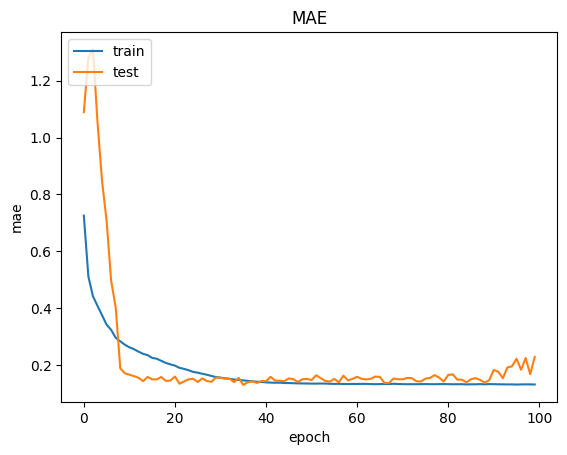

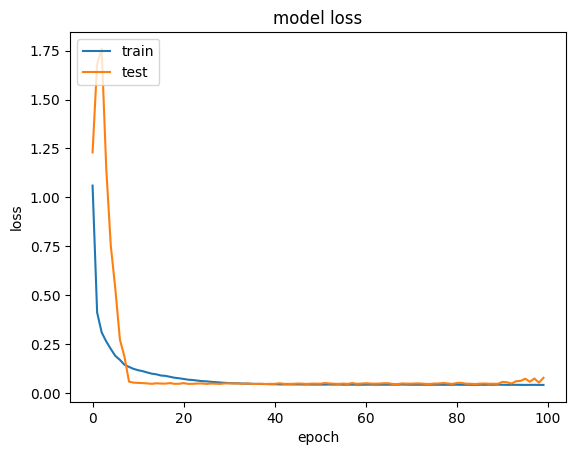

In [56]:
# Visualise NN

# Plotting Loss And Root Mean Square Error For both Training And Test Sets
plt.plot(epochs_hist.history['mae'])
plt.plot(epochs_hist.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('4.png')
plt.show()

## Cross validation

### Tune model?

In [53]:
# Grid search?